### Theory

#### Hypothesis Testing – The problem of multiple comparisons [5 points]

##### Question A
On the first experiment ($m = 1$) the chance that the results are significant given that the experiment lacks the power to reject is equal to $\alpha$. On the second experiment it is equal to $\alpha * P(\text{We didn't reject experiment } m-1)$. So

$$P(m^{th} \text{ experiment is significant | } m \text{ experiments lacking power to reject } H_0) = (1 - \alpha)^{m-1} * \alpha$$

Example:

$\alpha = 0.05$

$m = 6$

$P(6^{th} \text{ experiment is significant | } 6 \text{ experiments lacking power to reject } H_0) = (1-0.05)^{6-1}*0.05 \approx 0.038$

#### Question B

There is an increased chance of finding at least one false significant finding the more tests you perform. If m independent comparisons are performed, the family wise error rate (FWER) can be used. The formula for the FWER is the following:

$$\alpha_{fw} = 1-(1-\alpha)^{m}$$

so

$$P(\text{ at least one significant result | } m \text{ experiments lacking power to reject } H_0) = \alpha_{fw}$$

To arrive at this result, observe that this is $1 - P(m \text{ insignificant results | } m \text{ experiments lacking power to reject } H_0)$

Example:

$\alpha = 0.05$

$m = 6$

$\alpha_{fw} = 1-(1-0.05)^6\approx0.26$

#### Bias and unfairness in Interleaving experiments [10 points]
Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?

Ranking P

| D1 N |<br>
| D2 N |<br>
| D3 R |<br>

Ranking E

| D2 N |<br>
| D3 R |<br>
| D1 N |<br>

Because D3 is the only relevant document, we'd expect it's clicks to be attributed to E more often than to P.

The set of possible interleaved rankings using Team-Draft Interleaving is as follows:

| D1 N (P) | &emsp; | D1 N (P) | &emsp; | D2 N (E) | &emsp; | D2 N (E) | <br>
| D2 N (E) | &emsp; | D2 N (E) | &emsp; | D1 N (P) | &emsp; | D1 N (P) | <br>
| D3 R (P) | &emsp; | D3 R (E) | &emsp; | D3 R (P) | &emsp; | D3 R (E) | <br>

Where D3 is in the same position in all rankings, with equal assignments to P and E. Thus, in this case, the expected number of clicks is the same for both ranking functions even though ranking E should win. This is an example of insensitivy to the quality of rankings.

Example is based on: Hofmann, K., Whiteson, S., & De Rijke, M. (2011, October). A probabilistic method for inferring preferences from clicks. In Proceedings of the 20th ACM international conference on Information and knowledge management (pp. 249-258). ACM.

In [72]:
'''Import necessary python packages'''

import pyclick
from pyclick.utils import YandexRelPredChallengeParser
import pickle
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import itertools
import time
from collections import Counter
import seaborn as sns
import pandas as pd

### Step 1: Simulate Rankings of Relevance for E and P 

In [73]:
'''generate all combinations of all permuations of the relevance labels 'N', 'R' and 'HR'.'''

# Added the numbers to facilitate easy sorting.
REL_SCORES = {'N' : 0, 'R' : 1, 'HR' : 2}

# Generate all possible rankings for both Production and Experimental systems
P = list(itertools.product(REL_SCORES.keys(), repeat = 5))
E = list(itertools.product(REL_SCORES.keys(), repeat = 5))

# Generate all combinations of the permutations 
rankings = list(itertools.product(P, E))

# Example of the generated rankings
for p, e in rankings[0::10000]:
    print(p)
    print(e)
    print()

('R', 'R', 'R', 'R', 'R')
('R', 'R', 'R', 'R', 'R')

('R', 'N', 'N', 'N', 'HR')
('R', 'N', 'N', 'R', 'N')

('N', 'R', 'R', 'R', 'N')
('R', 'HR', 'HR', 'R', 'HR')

('N', 'N', 'N', 'HR', 'R')
('N', 'N', 'R', 'N', 'R')

('HR', 'R', 'R', 'R', 'HR')
('N', 'HR', 'N', 'N', 'N')

('HR', 'N', 'N', 'HR', 'N')
('HR', 'R', 'HR', 'N', 'HR')



### Step 2: Implement Evaluation Measures

The evaluation measures used for offline evaluation are:

* Precision at k
* nDCG at k
* Expected Reciprocal Rank

In [74]:
'''These are the function definitions for the methods to calculate the evaluation measures'''

def precision_at_k(ranking, k):
    subset = ranking[:k]
    n_relevant = 0
    
    for result in subset:
        if REL_SCORES[result] > 0:
            n_relevant += 1
    
    return n_relevant / k

def DCG_at_k(ranking, k, optimal=False):
    subset = ranking[:k]
    
    # Optionally sort the ranking to calculate the maximum possible score
    if optimal:
        subset = sorted(subset, reverse=True, key=lambda x: REL_SCORES[x])
        
    discounted_score = 0
    
    for i, result in enumerate(subset):
        # prepare variables for DCG formula
        rank = i + 1
        rel = REL_SCORES[result]
        
        # Calculate score
        score = (2**rel - 1) / np.log2(1 + rank)
        discounted_score += score
    
    # NB: sum is built into the for-loop
    return discounted_score
        
def nDCG_at_k(ranking, k):
    true = DCG_at_k(ranking, k)
    best = DCG_at_k(ranking, k, optimal=True)
    
    # This is to prevent dividing by 0. If the best possible DCG is 0, the
    # true DCG is also zero (because there are no relevant document is the top k)
    if best == 0.0: 
        return 0.0
    else:
        return true / best

def prob_of_relevance(grade, max_grade):
    return (2**grade - 1) / 2**max_grade

def ERR(ranking):
    """Algorithm to compute ERR in linear time, implemented based on 
    
    Chapelle, O., Metlzer, D., Zhang, Y., & Grinspan, P. (2009, November). 
    Expected reciprocal rank for graded relevance. In Proceedings of the 18th ACM conference
    on Information and knowledge management (pp. 621-630). ACM."""
    
    grades = [REL_SCORES[x] for x in ranking]
    max_grade = max(REL_SCORES.values())
    
    p = 1
    err = 0
    
    for r in range(len(grades)):
        R = prob_of_relevance(grades[r], max_grade)
        err += p * (R/(r+1))
        p *= (1 - R)
    
    return err

In [75]:
'''The following loop calculates the precision, nDCG and ERR values for all simulated ranking.

It has been said during the lectures that a user often only looks at the top results,
and that k = 3 is a reasonable depth for the evaluation.'''

depth = 3

precision_p = []
precision_e = []
dcg_p = []
dcg_e = []
err_p = []
err_e = []

for i, (p, e) in enumerate(list(rankings)):
    precision_p.append(precision_at_k(p, depth))
    precision_e.append(precision_at_k(e, depth))

    dcg_p.append(nDCG_at_k(p, depth))
    dcg_e.append(nDCG_at_k(e, depth))
    
    err_p.append(ERR(p))
    err_e.append(ERR(e))

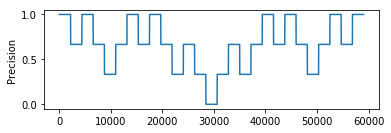

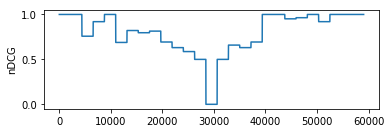

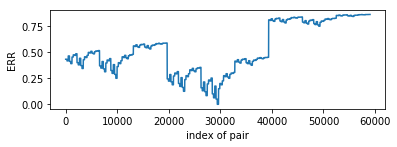

In [76]:
'''To have some idea about the range of the values of these measures, we plot the results 
of the production model'''

plt.figure(1)
plt.subplot(211)
plt.plot(range(len(precision_p)), precision_p)
plt.ylabel("Precision")

plt.figure(2)
plt.subplot(211)
plt.plot(range(len(dcg_p)), dcg_p)
plt.ylabel("nDCG")

fig = plt.figure(3)
plt.subplot(211)
plt.plot(range(len(err_p)), err_p)
plt.ylabel("ERR")
plt.xlabel("index of pair")

plt.show()

### Step 3: Calculate the 𝛥measure

We compare the measures for each ranking pair by calculating the difference of the experimental model and the production model. With those numbers a percentage can be calculated of the fraction of wins for model E.

In the assignment is says to only consider pairs for which E > P. But we found it easier to keep
all pairs, because we have to compare the results with the online rankings. If we discard some pairs,
the arrays don't line up anymore.

In [77]:
def delta_measure(scores_a, scores_b):
    return [b - a for a, b in zip(scores_a, scores_b)]

def percentage_of_wins_for_E(delta_values):
    return np.sum(np.array(delta_values) > 0) / len(delta_values)

# Calculate delta measure for the three chosen metrics
delta_precision = delta_measure(precision_p, precision_e)
delta_nDCG = delta_measure(dcg_p, dcg_e)
delta_ERR = delta_measure(err_p, err_e)

print("A subset of delta precisions: \n{}".format(delta_precision[0::10000]))
print("percentage of wins for E:\n", percentage_of_wins_for_E(delta_precision))
print()
print()
print("A subset of delta nDCGs \n{}".format(delta_nDCG[0::10000]))
print("Percentage of wins for E:\n", percentage_of_wins_for_E(delta_nDCG))
print()
print()
print("A subset of delta ERRs \n{}".format(delta_ERR[0::10000]))
print("Percentage of wins for E:\n", percentage_of_wins_for_E(delta_ERR))

A subset of delta precisions: 
[0.0, 0.0, 0.33333333333333337, 0.3333333333333333, -0.6666666666666667, 0.6666666666666667]
percentage of wins for E:
 0.331961591221


A subset of delta nDCGs 
[0.0, 0.0, 0.12114079868658267, 0.5, -0.36907024642854258, -0.048557341012844701]
Percentage of wins for E:
 0.427983539095


A subset of delta ERRs 
[0.0, -0.06562499999999999, 0.363671875, -0.07916666666666668, -0.44648437500000004, 0.038281250000000044]
Percentage of wins for E:
 0.497366593846


### Step 4:  Implement Interleaving

Balanced interleaving and Team-Draft interleaving both have their downsides like mentioned above. We went
with team-draft for this step because balanced interleaving was covered quite well in the lectures and
implementing team-draft would increase our understanding of the algorithm.

In [78]:
'''Here is the function definition of the algorithms'''

def team_draft_interleaving(A,B):
    # create teams
    team_a, team_b, I = 0, 0, []
    
    # While there are still documents not present in the interleaved list
    while any(set(A)-set(I)) and any(set(B)-set(I)):
        
        #Flip a coin
        turn = 'A' if random.randint(0, 1) == 0 else 'B'
        
        #If A wins the coin flip: put the highest ranked document of A
        # that is not yet in the interleaved list, in the interleaved
        if team_a < team_b or team_a == team_b and turn == 'A':
            for a in A:
                if a not in I:
                    I.append(a)
                    break
            team_a += 1
        # If B wins the flip: put the highest ranked document of A
        # that is not yet in the interleaved list, in the interleaved
        else:
            for b in B:
                if b not in I:
                    I.append(b)
                    break
            team_b += 1
    return(I[:5])

In [79]:
'''Genererates interleaved versions of all ranking pairs'''

team_interleaved_lists = []

for A,B in rankings:
    
    # Create a unique string for each document based on its position, the model that generated it
    # and its relevance label. This way the algorithm knows which document is in the interleaved
    # list already.
    A, B = [str(a) + "P" + str(i) for i, a in enumerate(A)], [str(b) + "E" + str(i) for i, b in enumerate(B)]
    
    interleaved_list_team = team_draft_interleaving(A,B)
    team_interleaved_lists.append(interleaved_list_team)

print('Example of the interleaved lists:')
for team in team_interleaved_lists[::10000]:
    print(team)

Example of the interleaved lists:
['RE0', 'RP0', 'RP1', 'RE1', 'RP2']
['RP0', 'RE0', 'NE1', 'NP1', 'NP2']
['NP0', 'RE0', 'RP1', 'HRE1', 'RP2']
['NE0', 'NP0', 'NE1', 'NP1', 'RE2']
['NE0', 'HRP0', 'HRE1', 'RP1', 'RP2']
['HRP0', 'HRE0', 'NP1', 'RE1', 'HRE2']


### Step 5:  Implement User Clicks Simulation

In [80]:
''' In this cell the Random click model is implemented. We use the PyClick module to parse the Yandex file.
Our TA assured us it is fine, if we use it just for the parsing of the Yandex file.
Furthermore we assume all queries should be used, even if none of the results are clicked'''

def execute_clicks(click_probs):
    """Returns a list of booleans indicating on which positions was clicked, based on the
    given click_probs (click probabilities)"""
    
    # Flip one coin for (and with) every probability in click_probs
    return np.random.binomial(1, p=click_probs)

def MLE_random_click(sessions):
    '''As slide 62 of lecture 3 shows, the MLE of a bernouilli distribution, rho, is just
    the ratio of clicks with respect to the total number of URls shown. 
    '''
    total_clicks = 0
    total_shown = len(sessions)*10
    
    for sesh in sessions:
        total_clicks += sum(sesh.get_clicks())
    
    rho = total_clicks/total_shown
    return rho
            
def random_click_probabilities(ranking, rho):
    '''probabilities of a click from the random clicking model'''
    return [rho] * len(ranking)

def simulate_random_click_model(ranking, rho, N):
    '''Generate N click patterns based on the random click model'''
    return [execute_clicks(random_click_probabilities(ranking, rho)) for _ in range(N)]

def sdbn_click_probabilities(ranking, alphas, sigmas):
    '''Probabilities of a click from the Simple Bayesian Dynamic Network'''
    
    # Assume zero probabilities
    click_probs = [0.0] * len(ranking)
    
    for i, relevance in enumerate(ranking):
        
        # Click when attracted
        alpha = alphas[relevance[:-2]]
        click_probs[i] = alpha
        
        # If satisfied, we do not evaluate the rest of the documents
        satisfied = float(np.random.choice([0,1], 1, p=[(1-sigmas[i]),(sigmas[i])]))
        if satisfied:
            break
    
    return click_probs

def simulate_sdbn_click_model(ranking, alphas, sigmas, N):
    '''Generate N click patterns based on the SDBN click model'''
    return [execute_clicks(sdbn_click_probabilities(ranking, alphas, sigmas)) for _ in range(N)]

In [81]:
'''We use the pyclick to interface with the dataset. We are aware that there are out-of-box
click models available in the package but we don't use those. We've checked this with our TA
and using it for this purpose was '''

parser = YandexRelPredChallengeParser.YandexRelPredChallengeParser()
search_sessions = parser.parse('YandexRelPredChallenge.txt')

## Our method of estimating sigmas for SDBN

For the Simple Dynamic Bayesian Network click model we learn the satisfaction parameter $\sigma_{u_rq}$, meaning we learn the satisfaction for each query and the document ID that was clicked last. The Maximum Likelihood estimation for the satisfaction becomes: 

<center>
    
$\sigma_{u_rq} = \frac{l_{u_rq}}{T_{u_rq}}$, 
</center>

where $l_{u_rq}$ is the count of events the document ID was clicked last given the query and $T_{u_rq}$ represents the total number of times the document ID was clicked for the query.

We are assuming that the document IDs are ranked deterministically, meaning that the query will always output the same 10 document IDs in the same order. This assumption allows us to discard the document ID information, and instead keep rank indication of a click given the query.

The resulting matrix consists of n-queries by 10-ranks, where each element carries the satisfaction parameter of a rank given the query. As query-rank satisfaction parameters are not useful to our relevance rankings, we need to estimate a general satisfaction parameter for each rank. We do this by calculating the mean of satisfaction parameters for all queries given a rank. This leaves us with a 1 by 10 vector; an average satisfaction parameter per rank.

In [82]:
'''Function definition of the MLE estimation for the satisfaction parameter'''

# Assumption: query always returns the same docIDs (ie. ranking is deterministic)

from collections import Counter

def learn_sdbn_satisfaction(search_sessions):
    last_click_ranks = dict()
    clicks_per_query = dict()
    last_total_ratio = dict()

    # Find last click rank per query:
    for session in search_sessions:
        
        # If get_last_click_rank returns 10, there hasn't been click action for the query.
        if session.get_last_click_rank() == 10:
            continue

        # Find last click:
        if session.query in last_click_ranks:
            last_click_ranks[session.query].append(session.get_last_click_rank())
        else:
            last_click_ranks[session.query] = [session.get_last_click_rank()]
            
        # Find all click ranks per query:
        if session.query not in clicks_per_query:
            clicks_per_query[session.query] = []

        for idx, val in enumerate(session.get_clicks()):
            if val == 1:
                clicks_per_query[session.query].append(idx)    

    # Calculate sigmas for each unique query and each of its ranks:
    for query in last_click_ranks.keys():
        last_total_ratio[query] = [0] * 10
    
        count_last = Counter(last_click_ranks[query])
        count_total = Counter(clicks_per_query[query])
    
        for rank in list(count_last):
            sigma = count_last[rank] / count_total[rank]
            
            last_total_ratio[query][rank] = sigma
            
    # Compose final list of average sigmas, i.e. 1 sigma for each rank:
    avg_sigmas = [0.0] * 10

    for query in list(last_total_ratio):
        avg_sigmas = [sum(sigma) for sigma in zip(last_total_ratio[query], avg_sigmas)]
    
    click_model = [sigma / len(last_total_ratio) for sigma in avg_sigmas]
    
    return last_click_ranks, clicks_per_query, last_total_ratio, click_model


last, total, sigmas, cm = learn_sdbn_satisfaction(search_sessions)

### Step 6: Simulate Interleaving Experiment

In [83]:
'''Function declarations for methods to calculate a winning model based on an interleaved
list (including attributions). '''

def experiment(clicks, interleaved_list):
    '''Does experiments for one interleaved list with a list of click patterns.
    Outputs a proportion of wins for E over all experiments, ties included.'''
    
    clicks = np.array(clicks)
    
    # Boolean array where each contribution of E is marked True
    E_docs = np.array([x[-2] == 'E' for x in interleaved_list])
    
    # Overlay of clicks and the boolean mask above. Evaluates
    # to True if a rank has been clicked and was contributed by E.
    # Finally sum those Truths (1s) to get total clicks on E per experiment
    E_clicks = np.sum(np.logical_and(E_docs, clicks), axis=1)
    
    # Clicks on P are the difference of total clicks and E-clicks
    P_clicks = np.sum(clicks, axis=1) - E_clicks
    
    return  np.sum(E_clicks > P_clicks) / len(clicks)

In [84]:
''' 
---- NB!!! ----- Don't run this cell.

In this cell the experiments for the random click model and the SDBN are run. Because you have
to run 100 experiments per ranking pair, this takes a very long time (dozens of minutes). We've
ran on our systems and saved the results to a .pickle file so you don't have to run this cell if you
don't want to'''

E_win_proportions = {
    'random_team' : [],
    'sdbn_team' : []
}

# Estimates for alpha_uq from relevance labels

# Katja Hofmann, Anne Schuth, Shimon Whiteson, and Maarten de Rijke. Reusing historical interaction
# data for faster online learning to rank for IR. In WSDM, 2013. ACM Press. 69, 70, 77

# We will be using the navigational model in the experiment because we feel it
# is the most natural representation of real user behaviour (in our experience).

alpha = {
    'perfect' : {'N' : 0.0, 'R' : 0.5, 'HR' : 1.0},
    'navigational' : {'N' : 0.05, 'R' : 0.5, 'HR' : 0.95},
    'informal' : {'N' : 0.4, 'R' : 0.7 , 'HR' : 0.9}
}

# Calculate the Rho for the random click model
rho = MLE_random_click(search_sessions)

N = 100
start = time.time()
for i in range(len(team_interleaved_lists)):
    if i % 500 == 0 and i > 0:
        print("{} / {} \t\t at {}/sec".format(i+1, len(team_interleaved_lists), (i+1)/(time.time() - start)))
    
    # Random Click Model simulation
    random_clicks = simulate_random_click_model(team_interleaved_lists[i], rho, N)
    E_win_proportions['random_team'].append(experiment(random_clicks, team_interleaved_lists[i]))
    
    # SDBN simulation
    sdbn_clicks = simulate_sdbn_click_model(team_interleaved_lists[i], alpha['navigational'], cm, N)
    E_win_proportions['sdbn_team'].append(experiment(sdbn_clicks, team_interleaved_lists[i]))

pickle.dump(E_win_proportions, open( "e_win_proportions_N100.p", "wb" ) )

501 / 59049 		 at 24.34957464271034/sec
1001 / 59049 		 at 24.32486355359581/sec
1501 / 59049 		 at 24.239185454987872/sec
2001 / 59049 		 at 24.39247438662286/sec
2501 / 59049 		 at 24.49793054289853/sec
3001 / 59049 		 at 24.439444141410668/sec
3501 / 59049 		 at 24.24946601952161/sec
4001 / 59049 		 at 24.074069531701348/sec
4501 / 59049 		 at 24.039274741734/sec
5001 / 59049 		 at 23.877943171176042/sec
5501 / 59049 		 at 23.78228413426507/sec
6001 / 59049 		 at 23.764989311399333/sec
6501 / 59049 		 at 23.5421807817041/sec
7001 / 59049 		 at 23.537596220481312/sec
7501 / 59049 		 at 23.467454233925295/sec
8001 / 59049 		 at 23.38480917322269/sec
8501 / 59049 		 at 23.330169647303357/sec
9001 / 59049 		 at 23.336633602898683/sec
9501 / 59049 		 at 23.288703657448465/sec
10001 / 59049 		 at 23.21722177085195/sec
10501 / 59049 		 at 23.178490474978293/sec
11001 / 59049 		 at 23.122561261356505/sec
11501 / 59049 		 at 23.05350068983978/sec
12001 / 59049 		 at 23.014836847552324/sec
12

In [86]:
'''Import the results of the experiments in the cell above.'''

with open('e_win_proportions_N100.p', 'rb') as file:
    E_win_proportions = pickle.load(file)

### Step 7: Analysis

### Testing methodology

In the paper "Large-Scale Validation and Analysis of Interleaved Search Evaluation" it is mentioned that non-parametric significance tests like bootstrap methods require fewer assumptions. The above test of normality gives an indication why this can be important (e.g. doing a t-test wouldn't make sense in the abov. Following the paper we also addopt a bootstrapping method to compare the online and offline evaluations. We try to do that by assessing if the expert evaluations match with the online evalutations. As mentioned in the paper "Agreement between expert judgments and interleaving builds confidence that both methods accurately reflect user satisfaction with search result". However, one must keep in mind that this is still no guarantee.

In [87]:
def datasampler(nr_samples):
    '''Collects win statistics on N pairs sampled uniformly from the list of all possible rankings.'''    
    ranking_sample_nrs = []
    
    # Generate unique random ints between 0 and len(rankings)
    while len(ranking_sample_nrs) < nr_samples:
        sample = random.randint(0, len(rankings) - 1)
        if sample not in ranking_sample_nrs:
            ranking_sample_nrs.append(sample) 

    # Initialize a massive dictionary to make analyses simple
    experiment = {
        "nr_samples" : nr_samples,
        "ranking_idx" : ranking_sample_nrs,
        "ranking_pairs" : [],
        "precision_p" : [],
        "precision_e" : [],
        "d_precision" : [],
        "dcg_p" : [],
        "dcg_e" : [],
        "d_dcg" : [],
        "err_p" : [],
        "err_e" : [],
        "d_err" : [],
        "offline_depth" : depth,
        "offline_wins" : {
            "precision" : 0.0,
            "dcg" : 0.0,
            "err" : 0.0,
        },
        "team" : {
            "interleaved" : [],
            "random_prop" : [],
            "sdbn_prop" : [],
            "wins_random" : 0,
            "wins_sdbn" : 0
        }
    }

    # Filter all lists from te notebook on the sampled ids:
    for idx in ranking_sample_nrs:
        experiment["ranking_pairs"].append(rankings[idx])
        experiment["precision_p"].append(precision_p[idx])
        experiment["precision_e"].append(precision_e[idx])
        experiment["d_precision"].append(delta_precision[idx])
        experiment["dcg_p"].append(dcg_p[idx])
        experiment["dcg_e"].append(dcg_e[idx])
        experiment["d_dcg"].append(delta_nDCG[idx])
        experiment["err_p"].append(err_p[idx])
        experiment["err_e"].append(err_e[idx])
        experiment["d_err"].append(delta_ERR[idx])
        
        
        # Get sampled elements from all global variables in the notebook and store in dict:
        experiment["team"]["interleaved"].append(team_interleaved_lists[idx])
        experiment["team"]["random_prop"].append(E_win_proportions['random_team'][idx])
        experiment["team"]["sdbn_prop"].append(E_win_proportions['sdbn_team'][idx])

    # Derive win percentages from dict entries:
    experiment["offline_wins"]["precision"] = percentage_of_wins_for_E(experiment["d_precision"])
    experiment["offline_wins"]["dcg"] = percentage_of_wins_for_E(experiment["d_dcg"])
    experiment["offline_wins"]["err"] = percentage_of_wins_for_E(experiment["d_err"])

    experiment["team"]["wins_random"] = np.mean(experiment["team"]["random_prop"])
    experiment["team"]["wins_sdbn"] = np.mean(experiment["team"]["sdbn_prop"])    
    
    return experiment

In [88]:
'''This cell perfoms the bootstapping procedure to be able to to build confidence intervals 
around the mean values for the evaluation measures.'''

# Rounding method, allowing us to round at 0.005 level. This influences the results, but since
# on average you round up the same amount of times as you round down this is not a big issue.
def myround(x, prec=3, base=.005):
    return round(base * round(float(x)/base),prec)

myround(round(0.8034598076, 3))


# Initialize a massive dictionary to make analyses simple
bootstrapping_data = {
    "offline_wins" : {
        "precision" : Counter(),
        "dcg" : Counter(),
        "err" : Counter()
    },
    "team" : {
        "wins_random" : Counter(),
        "wins_sdbn" : Counter(),
    }
}

for i in range(10000):
    experiment_result = datasampler(200)

    bootstrapping_data["offline_wins"]["precision"][myround(round(experiment_result["offline_wins"]["precision"], 3))]+=1 
    bootstrapping_data["offline_wins"]["dcg"][myround(round(experiment_result["offline_wins"]["dcg"], 3))] +=1
    bootstrapping_data["offline_wins"]["err"][myround(round(experiment_result["offline_wins"]["err"], 3))]+=1 
    bootstrapping_data["team"]["wins_random"][myround(round(experiment_result["team"]["wins_random"], 3))] +=1 
    bootstrapping_data["team"]["wins_sdbn"][myround(round(experiment_result["team"]["wins_sdbn"], 3))]+=1 


In [89]:
'''Fuction to plot the bootstap data'''

def plot_histogram_with_confidence(data_counter, alpha, title):
    
    fig, ax = plt.subplots(figsize=(24, 12))

    # Create graph attributes:
    stats = list(data_counter.elements())

    # Find the lower bound of the the confidence interval
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))

    # Find the upper bound of the confidence interval
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    mean = np.mean(stats)

    # Find the indices corresponding to the bins of the mean, and the boundries of the
    # confindence interval for
    mean_idx = sorted(list(data_counter.keys())).index(myround(round(mean, 3)))
    lower_idx = sorted(list(data_counter.keys())).index(myround(round(lower, 3)))
    upper_idx = sorted(list(data_counter.keys())).index(myround(round(upper, 3)))

    labels, values = zip(*sorted(data_counter.items()))

    # Define indexes for bins
    indexes = np.arange(len(labels))
    width = 1

    # Plot lines of the confindence interval
    plt.axvline(mean_idx, color='r')
    plt.axvline(lower_idx, color='r')
    plt.axvline(upper_idx, color='r')

    # Plot the histogram
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)

    ax.set_xlabel('Percentage wins E') 
    ax.set_ylabel('Number of occurences (total = 10000)')
    ax.set_title(title)
    
    plt.show()
    
    return lower, upper, mean

## Figures

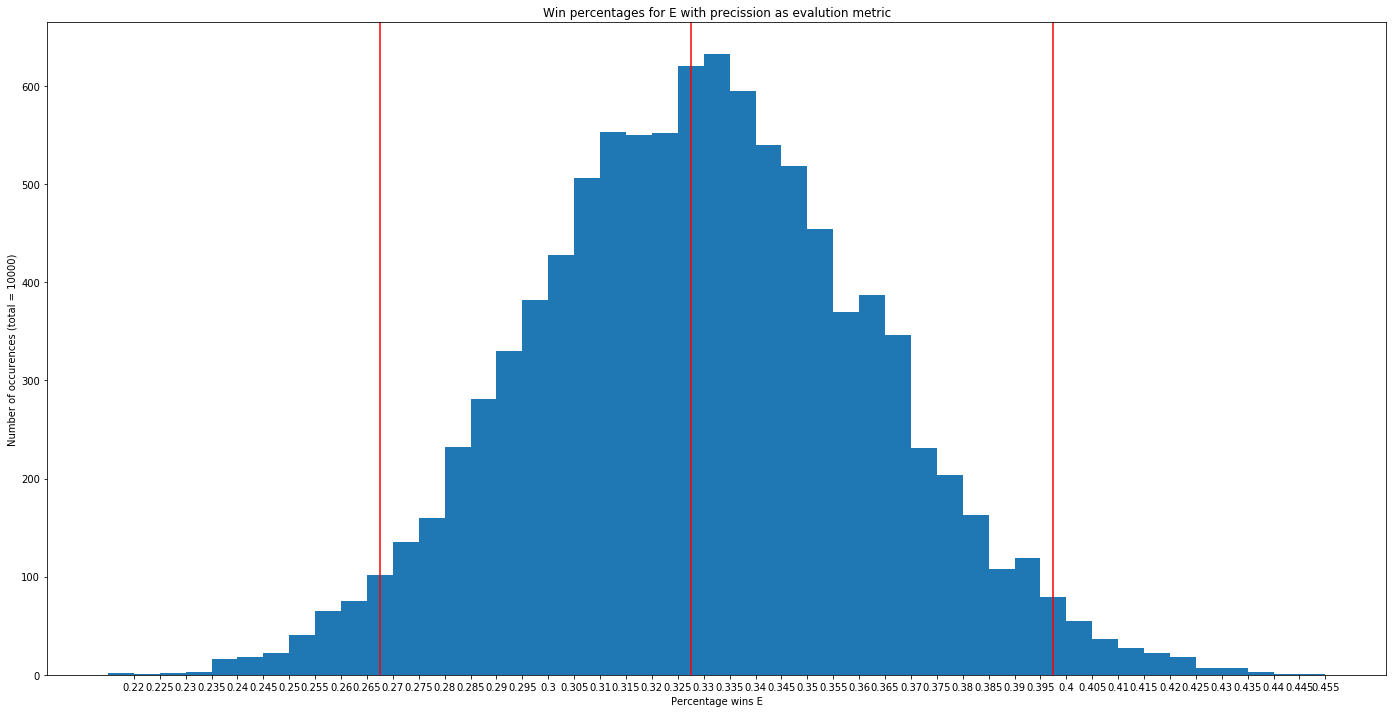

95.0 confidence interval: 27.0% and 40.0%, with mean at 0.332


In [90]:
# Global confidence level
CONFIDENCE_LEVEL = 0.95

'''Histogram for the offline precision'''

low_precision, up_precision, mean_precision = plot_histogram_with_confidence(bootstrapping_data['offline_wins']['precision'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages for E with precission as evalution metric')

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_precision*100, up_precision*100, mean_precision))



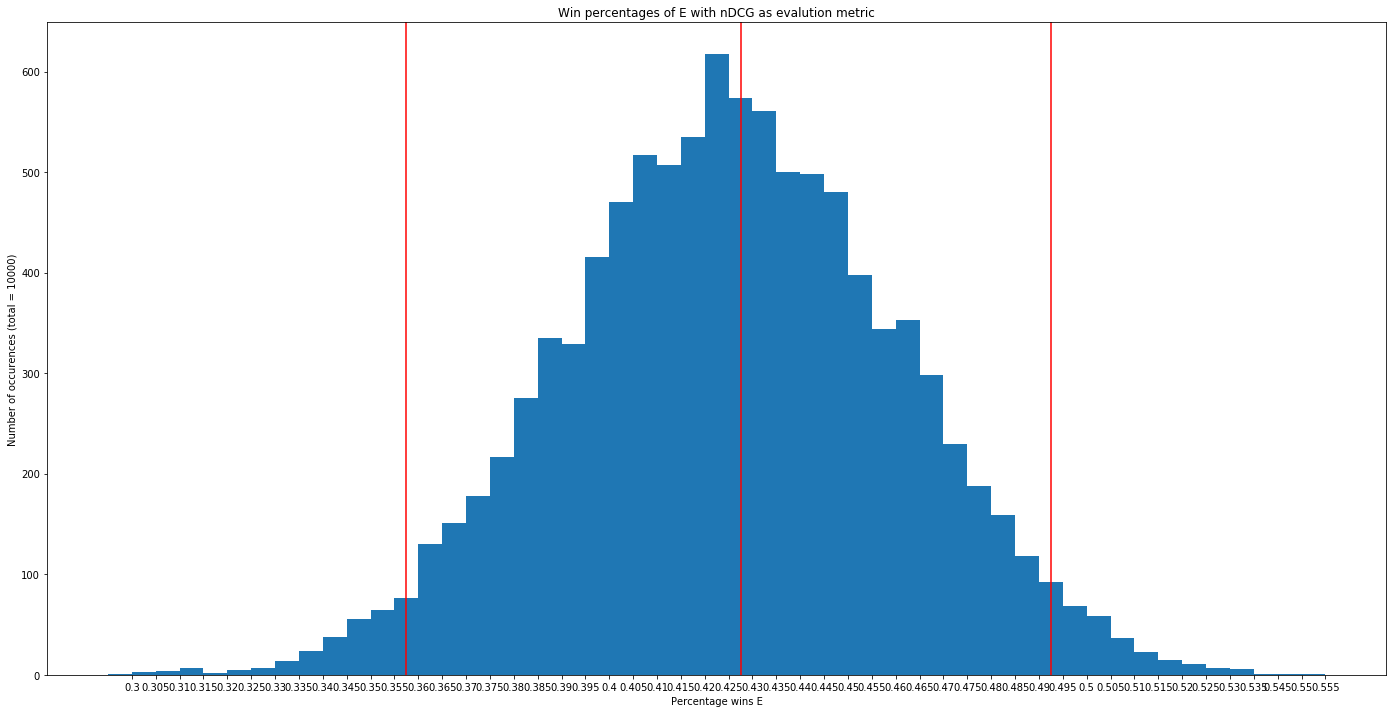

95.0 confidence interval: 36.0% and 49.5%, with mean at 0.428


In [91]:
'''Histogram for the offline normalized discounted cumulative gain'''

low_nDCG, up_nDCG, mean_nDCG = plot_histogram_with_confidence(bootstrapping_data['offline_wins']['dcg'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages of E with nDCG as evalution metric')

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_nDCG*100, up_nDCG*100, mean_nDCG))

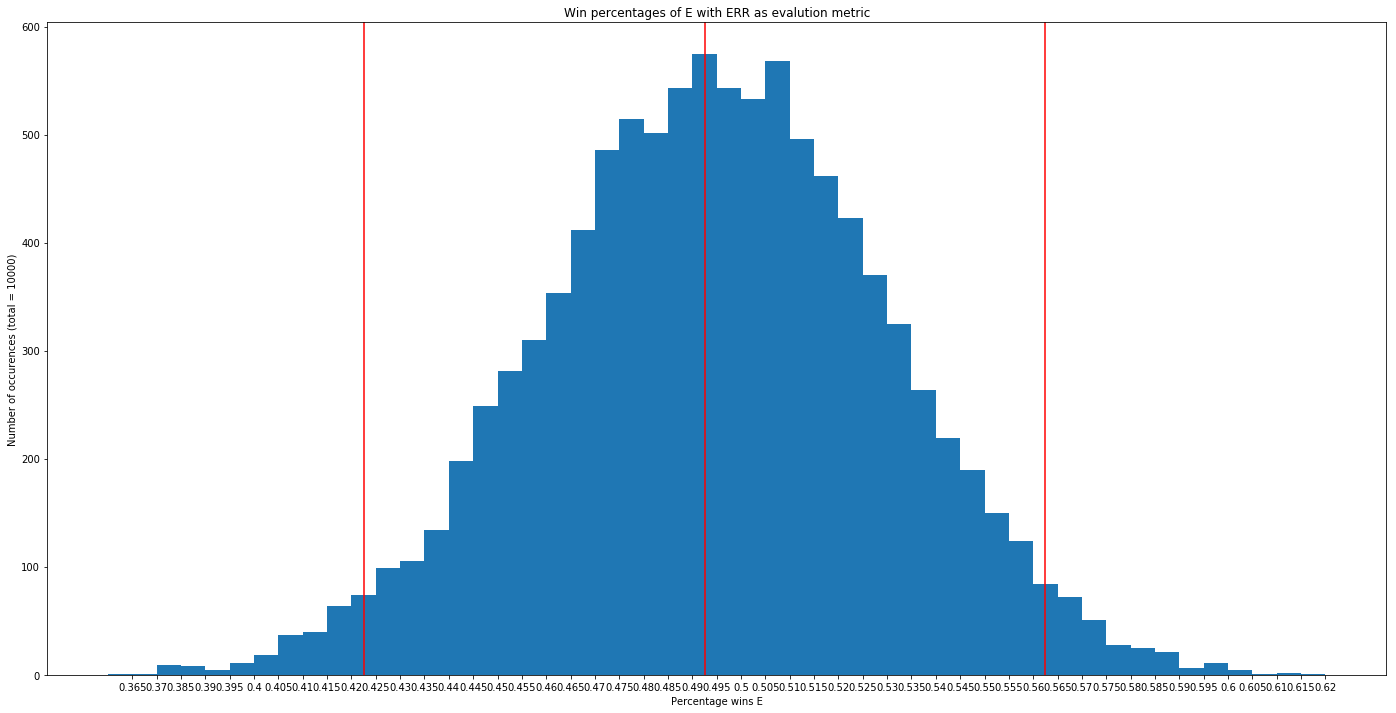

95.0 confidence interval: 42.5% and 56.5%, with mean at 0.497


In [92]:
'''Histogram for the offline Expected Reciprocal Rank'''

low_ERR, up_ERR, mean_ERR = plot_histogram_with_confidence(bootstrapping_data['offline_wins']['err'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages of E with ERR as evalution metric')

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_ERR*100, up_ERR*100, mean_ERR))

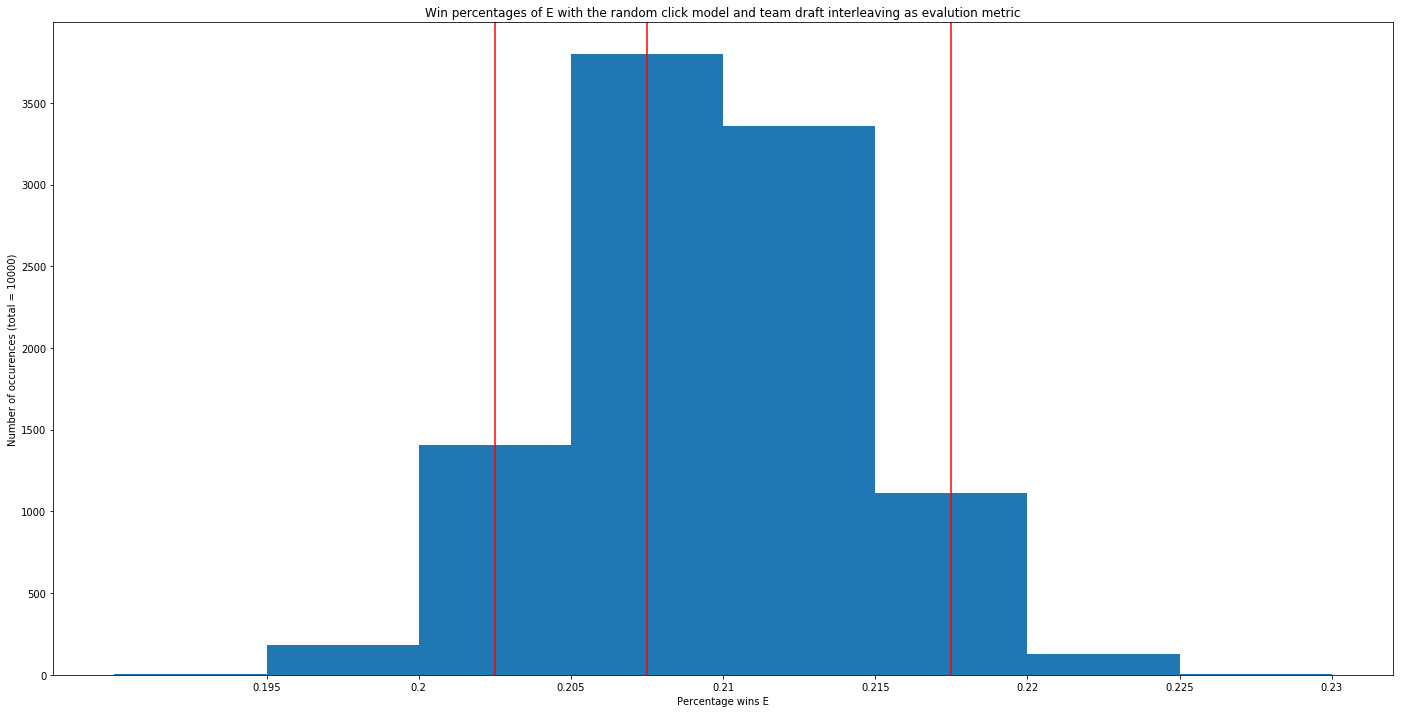

95.0 confidence interval: 20.5% and 22.0%, with mean at 0.212


In [95]:
'''Histogram for interleaving with the random click model'''

low_random, up_random, mean_random = plot_histogram_with_confidence(bootstrapping_data['team']['wins_random'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages of E with the random click model and team draft interleaving as evalution metric')

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_random*100, up_random*100, mean_random))

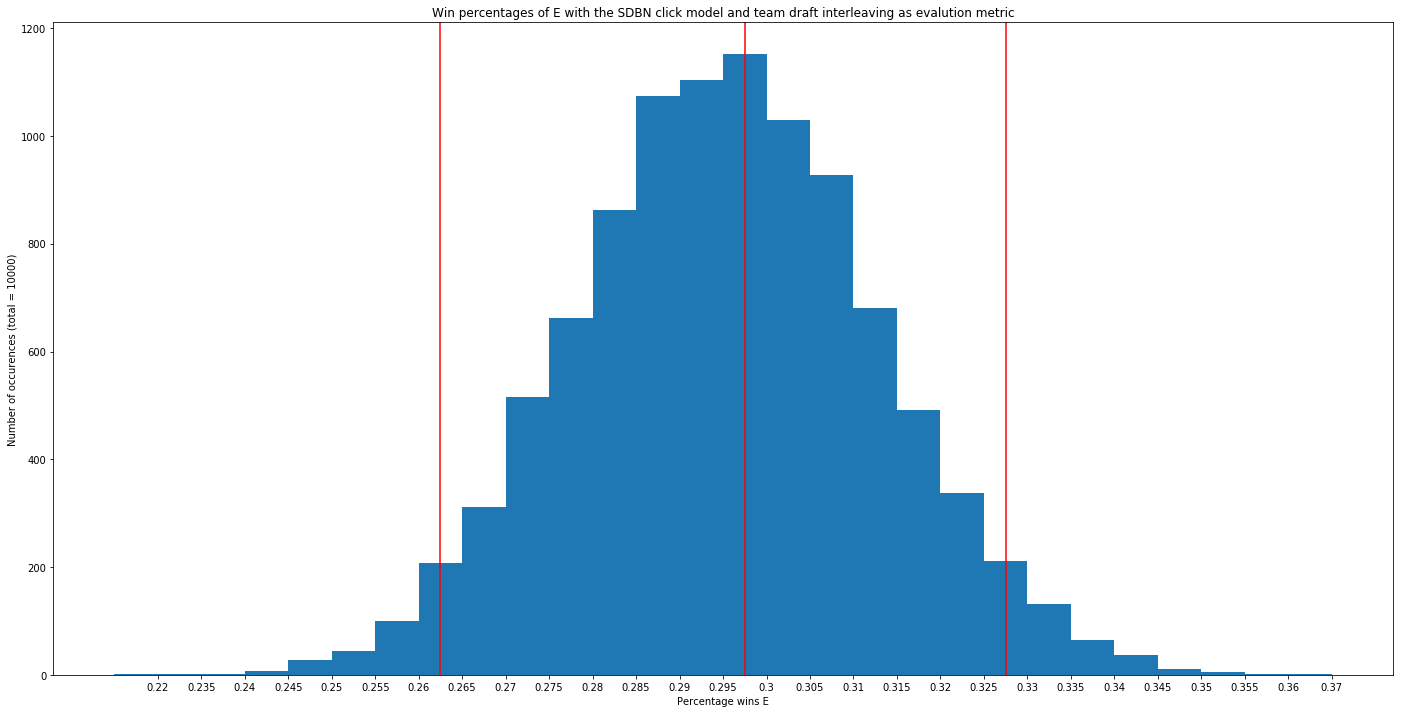

95.0 confidence interval: 26.5% and 33.0%, with mean at 0.298


In [96]:
low_sdbn, up_sdbn, mean_sdbn = plot_histogram_with_confidence(bootstrapping_data['team']['wins_sdbn'], 
                                                                           CONFIDENCE_LEVEL, 
                                                                           'Win percentages of E with the SDBN click model and team draft interleaving as evalution metric')

print('%.1f confidence interval: %.1f%% and %.1f%%, with mean at %.3f' % (CONFIDENCE_LEVEL*100, low_sdbn*100, up_sdbn*100, mean_sdbn))

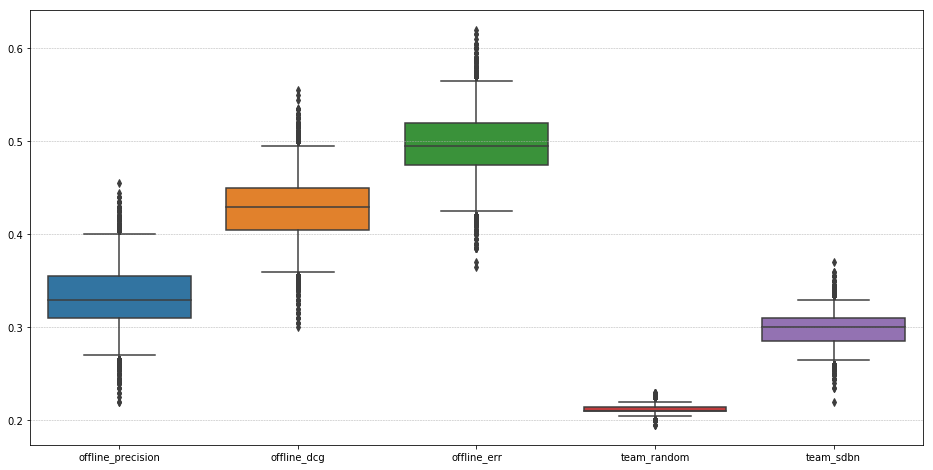

In [97]:
'''Plot boxplots of the confidence intervals in a figure.'''

# Prepare the data by concatenating all values and adding names to datapoints
values = np.concatenate((np.array(list(bootstrapping_data["offline_wins"]["precision"].elements())),
                         np.array(list(bootstrapping_data["offline_wins"]["dcg"].elements())),
                         np.array(list(bootstrapping_data["offline_wins"]["err"].elements())),
                         np.array(list(bootstrapping_data["team"]["wins_random"].elements())),
                         np.array(list(bootstrapping_data["team"]["wins_sdbn"].elements()))), 0)

names = np.concatenate((np.array(["offline_precision"]*10000),
                        np.array(["offline_dcg"]*10000),
                        np.array(["offline_err"]*10000),
                        np.array(["team_random"]*10000),
                        np.array(["team_sdbn"]*10000)), 0)

complete_data = {'value' : values, 'name' : names}

fig, ax = plt.subplots(figsize=(16, 8))

ax.grid(linestyle='--', linewidth=0.5)
p1=sns.boxplot(x='name', y='value', whis=[2.5,97.5], data=complete_data)

plt.show()

### Analyses plots and confidence intervals

### Offline measures

There is quite a difference in the means of the offline measures. We believe this is due the the number between the pairs. This amount depends on two factors. The first is that the outcomes of the precision formula are much less nuanced than the other. Nuanced in the sense that it is a simple fraction of number of relevant documents and the k parameter. The other measures are more involved calculations resulting in a wider range of possible values. Therefore the evaluations end in a tie more often for the precision, resulting in a lower win percentage for the experimental model. The other factor follows the same reasoning but then considering that precision and nDCG were computed at rank 3 thand ERR is computed over the entire ranking (resulting in more ties for the former two measures).

### Interleaving


### Offline vs online measures

### Remarks

Because of the setting of this experiment (not having real documents or users), some simplifyig assumptions had to be made. These assumptions might have affected the results. First of all, the estimation procedure satisfaction parameter in the SDBN model was modified to make it easier to apply to the simulated data. Instead of query-document pairs, the numbers were computed on query-rank pairs. This is under the assumption that for a given query, the same document is always at that rank. So satisisfaction is based on the clicked rank. You could say it is more of a replacement for the continuation parameter (since $\gamma = 1$ in simplified DBN). After each evaluation, the user model gradually lowers the bar for satisfaction. This brings the model closer to the Position Based Model than in its original formulation.
More straight forward is the fact that we have predefined alphas based on just the relevance labels. There is now neither query nor document information encoded in the attractiveness. This could result in the outcomes of the online experiments to be closer to the offline results than would be the case for alphas estimated based on query-document pairs.

### Mean testing
To be able to do a t-test we must first confirm that the data follows a normal distribution. For this purpose the Omnibus test by D'agostino and Pearson is used (D’Agostino, R. and Pearson, E. S. (1973), “Testing for departures from normality,” Biometrika, 60, 613-622). The experimental data is generated with an N=100, meaning 100 experiments for all interleaved rankings per click model are simulated.



In [293]:

# Test if data is normaliy distributed
def normality_test(metric_data, metric_name):
    
    # Convert the counter to an array
    data = []
    dictkeys = metric_data.keys()
    dictcounts = metric_data.values() 
    for i in range(len(metric_data)):
        data.extend([list(dictkeys)[i] for x in range(list(dictcounts)[i])])
    
    data=sorted(data)
    if stats.normaltest(data, axis=0)[1] < 0.05:
        print('The p-value for the normality test of the win percentages of %s is %.3f. This means that the win percentages are not normally distributed and a t-test cannot be performed'%(metric_name, stats.normaltest(data, axis=0)[1]))
    
    else:
        print('The p-value for the normality test of the win percentages of %s is %.3f. This means that the win percentages are normally distributed and a t-test can be performed'%(metric_name, stats.normaltest(data, axis=0)[1]))
    
    return
    
    
# print(bootstrapping_data['team']['wins_sdbn'])
# # print(len(bootstrapping_data['team']['wins_sdbn']))
# print(bootstrapping_data['team']['wins_sdbn'].keys())
# print(bootstrapping_data['team']['wins_sdbn'].values())
normality_test(bootstrapping_data['team']['wins_sdbn'],'SDBN')

The p-value for the normality test of the win percentages of SDBN is 0.018. This means that the win percentages are not normally distributed and a t-test cannot be performed


In [ ]:
metrics = [bootstrapping_data['team']['wins_sdbn'],bootstrapping_data['team']['wins_sdbn']]
for metric in metrics:
    normality_test(metric_data, metric_name)